In [1]:
import h5py 
import sys, warnings

import numpy as np 
import numpy.matlib as matlib 

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

from extra_data import RunDirectory 

from scipy import stats 
from IPython.display import clear_output  

import logging 
logging.captureWarnings(True) 

from sklearn.mixture import GaussianMixture 

# Setting up a random generator 
def_rng = np.random.default_rng() 

In [2]:
PREFIX='/gpfs/exfel/exp/SPB/202202/p003046/'

## Functions

In [3]:
run = RunDirectory(path=f'/pnfs/xfel.eu/exfel/archive/XFEL/raw/SPB/202202/p003046/r0{193}')  
run['SA1_XTD2_XGM/XGM/DOOCS:output']['data.intensitySa1TD']

<extra_data.KeyData source='SA1_XTD2_XGM/XGM/DOOCS:output' key='data.intensitySa1TD' for 2917 trains>

In [4]:
import xarray

def read_run_sync_trains(r, verbose=True):
    #clear_output(wait=False) 
    #sys.stderr.write(f'Processing run {r}...\n') 
    run = RunDirectory(path='/pnfs/xfel.eu/exfel/archive/XFEL/raw/SPB/202202/p003046/r%04d' % (r))  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
    ], require_all=True)
    if(verbose):
        sel.info()
    
    intensity_sase1_extra = sel['SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']
    intensity_preattenuator_sase1_extra = sel['SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']    
    motors_x_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_X.actualPosition.value']
    motors_y_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_Y.actualPosition.value']

    # Put the data in xarray
    motor_x = motors_x_extra.xarray()
    motor_y = motors_y_extra.xarray()
    xgm = intensity_sase1_extra.xarray()
    xgm2 = intensity_preattenuator_sase1_extra.xarray()
    
    directory = '/gpfs/exfel/u/scratch/SPB/202202/p003046/data' 
    agipd_frames_per_train = 202 # number of agipd frames per train
    with h5py.File(directory+'/r%04d_proc_radavg.h5' % (r)) as rad: 
        radavg = rad['entry_1']['radialavg'][:]
        trainIds = rad['entry_1']['trainId'][:]
        q = rad['entry_1']['q'][:]
    
    # Reshape the arrays from the radavg file to make them by train
    print(radavg.shape)
    radavg = radavg.reshape((-1,agipd_frames_per_train,radavg.shape[1]))
    trainIds = trainIds.reshape((-1,agipd_frames_per_train))
    # Ensure all the trains are the same length
    if (trainIds == trainIds[:,:1]).all() != True:
        raise ValueError        
    if(verbose):
        print("Reshaping of radavg successful:", (trainIds == trainIds[:,:1]).all())
    trainIds = trainIds[:,0]
    
    # Put radavg in an xarray
    radavg = xarray.DataArray(data=radavg, dims=('trainId', 'pulseNr', 'q'), 
                              coords={'trainId': trainIds, 'pulseNr': np.arange(agipd_frames_per_train), 'q': q})

    # Find trains which are common between radavg and the rest
    common_trains = np.intersect1d(intensity_sase1_extra.train_id_coordinates(), trainIds)
    if verbose:
        print("Found %d common train IDs between radavg and the rest" % len(common_trains))

    # Find the indices of the common trainIds and keep only those
    common_train_idx = np.searchsorted(intensity_sase1_extra.train_id_coordinates(),common_trains)
    motor_x = motor_x[common_train_idx]
    motor_y = motor_y[common_train_idx]
    xgm = xgm[common_train_idx]

    # Find the indices of the common trainIds for radavg    
    common_train_idx = np.searchsorted(radavg.coords['trainId'].data,common_trains)
    radavg = radavg[common_train_idx]
    
    train_ids_eq = (motor_x.coords['trainId'].data == radavg.coords['trainId'].data)
    if verbose:
        print("Train IDs all match:", train_ids_eq.all())
    
    return xgm, motor_x, motor_y, radavg, xgm2

In [5]:

def sync_pulses(xgm, radavg, xgm2):
    # Find out how many X-ray pulses per train

    npulses = np.sum(np.nanmean(xgm,axis=0) > 1.0)
    # For certain runs we actually receive more than 176 pulses, but the agipd will only record 176   
    npulses = min(npulses,176)
    agipd_frames_per_pulse = 176//npulses
    return xgm[:,:npulses], radavg[:,1:npulses*agipd_frames_per_pulse+1:agipd_frames_per_pulse,:], xgm2[:,:npulses]

In [6]:
def integrate_q_range(radavg, q_min = 0.73, q_max = 13, verbose=True):
    # q_min and q_max in 1/nm

    q = radavg.coords['q'].data
    q_min_idx = np.argmax(q > q_min)
    q_max_idx = np.argmax(q > q_max)
    
    if(verbose):
        print('Integrating between %g-%g 1/nm' % (q_min,q_max))   
    I = xarray.DataArray(data=np.nansum(radavg[:,:,q_min_idx:q_max_idx],axis=2), dims=('trainId', 'pulseNr'), coords={'trainId': radavg.coords['trainId'], 'pulseNr': radavg.coords['pulseNr']})
    return I

In [7]:
def linear_fit_trains(xgm, I, n=1, do_corr = False):
    # Do a linear fit of the intensity I versus the xgm, n consecutive trains at a time
    # The default is to do one train at a time (n=1)
    slopes = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    intercept = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    R2 = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    RelError = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    Pearson_R = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    
    for i,idx in enumerate(np.arange(0,xgm.shape[0],n)):
        fit = stats.linregress(xgm.data[idx:idx+n].flatten(), I.data[idx:idx+n].flatten())
        if(do_corr):
            Pearson_R[i] = np.corrcoef(xgm.data[idx:idx+n].flatten(), I.data[idx:idx+n].flatten())[0,1]            
        slopes[i] = fit.slope
        intercept[i] = fit.intercept
        R2[i] = fit.rvalue**2
        fit_values = xgm.data[idx:idx+n].flatten()*fit.slope + fit.intercept
        RelError[i] = np.nanmean(np.abs((I.data[idx:idx+n].flatten() - fit_values)/fit_values))

    if(do_corr):
        return slopes, intercept, R2, RelError, Pearson_R
    else:
        return slopes, intercept, R2, RelError

In [8]:
def xgm_range_normalized_R2(xgm, xgm2, R2, n=1):
    # Calculate the correlation between the XGMs
    _, _, R2_xgm, _ = linear_fit_trains(xgm, xgm2, n)
    # Use the XGM correlation to normalize the intensity correlation
    # Any large variations in the XGM correlation must be due to 
    # change in its range which should have no bearing on the quality
    # of the sheet
    return 1-(1-R2)*(1/(1-R2_xgm))*(1-np.mean(R2_xgm))

In [9]:
def plot_xgm_vs_I(xgm, I, sample_trains = 4, subsample_plot = 10):

    if(np.isscalar(sample_trains)):
        # If we pass a number as sample_trains, interpret it as the number of random trains
        sample_trains = np.sort(np.random.choice(xgm.shape[0], size=sample_trains, replace=False))
    else:
       # Otherwise interpret it as the list of trains to show as a sample
        sample_trains = np.sort(np.array(sample_trains))
    
    # Plotting the scatter plots 
    fig_handle = plt.figure(figsize=(20,20)) 
    spec_handle = fig_handle.add_gridspec(nrows = 2, ncols = 2) 

    xgm_sample = xgm[sample_trains]
    I_sample = I[sample_trains]
    
    fit = stats.linregress(xgm_sample.data.flatten(), I_sample.data.flatten())
    # Plotting selected single-train AGIPD/XGM correlation 
    ax_i = fig_handle.add_subplot(spec_handle[0,0])
    for t in sample_trains:
        im_i = plt.scatter(xgm[t], I[t],s=5,label=t)
    ax_i.legend(title='Sample trains', loc='lower right')
    
    xgm_limits = np.array([xgm.min(),xgm.max()])
    ax_i.plot(xgm_limits, (fit.slope * xgm_limits + fit.intercept) , "--k", linewidth = 1) 
    ax_i.set_title('Sample Trains') 
    ax_i.set_ylabel('Integrated Intensity (ADU)') 
    ax_i.set_xlabel('XGM Pulse Energy (uJ)') 
    ax_i.annotate("$R^2$= " + str("%0.5f" % fit.rvalue**2), xy = (0.05, 0.95), 
                    xycoords = "axes fraction", size = 12); 
    ax_i.set_xlim(left=0)
    ax_i.set_ylim(bottom=0)
    
    # Plotting selected multi-train AGIPD/XGM correlation 
    fit = stats.linregress(xgm.data.flatten(), I.data.flatten())
    train = xgm.coords['trainId'].data
    # Give the train number relative to the start of the run
    train -= train[0]
    c_points = np.broadcast_to(train.reshape((-1,1)), xgm.shape)

    ax_i = fig_handle.add_subplot(spec_handle[0,1]) 
    im_i = plt.scatter(xgm[:,::subsample_plot],I[:,::subsample_plot],s=5,c=c_points[:,::subsample_plot]) 
 
    ax_i.plot(xgm_limits, (fit.slope * xgm_limits + fit.intercept) , "--k", linewidth = 1) 
    ax_i.annotate("$R^2$= " + str("%0.5f" % fit.rvalue**2), xy = (0.05, 0.95), 
                    xycoords = "axes fraction", size = 12)
    ax_i.set_title('Entire Run') 
    ax_i.set_ylabel('Integrated Intensity (ADU)') 
    ax_i.set_xlabel('XGM Pulse Energy (uJ)') 
    ax_i.set_xlim(left=0)
    ax_i.set_ylim(bottom=0)
    plt.colorbar()
#    plt.show()
    
    ax_i = fig_handle.add_subplot(spec_handle[1,0])
    plt.plot(np.max(xgm,axis=1)-np.min(xgm,axis=1))
    plt.xlabel('Train') 
    plt.ylabel('XGM Max-Min') 
    plt.title('XGM Range per Train')  
    
    ax_i = fig_handle.add_subplot(spec_handle[1,1])
    plt.plot(np.mean(xgm,axis=1))
    plt.xlabel('Train') 
    plt.ylabel('XGM Mean') 
    plt.title('XGM Mean per Train')  
    plt.show()

In [10]:
from matplotlib import colors

def plot_R2_vs_motor(R2, motor_x, motor_y, vmax=25):
    if np.std(motor_x) > np.std(motor_y):
        motor = motor_x
        axis = 'x'
    else:
        motor = motor_y
        axis = 'y'
    fig_handle = plt.figure(figsize=(20,20))
    spec_handle = fig_handle.add_gridspec(nrows = 3, ncols = 2)
    ax_i = fig_handle.add_subplot(spec_handle[0,0])
    _ = plt.hist2d(motor,R2,bins=[25,256],vmax=vmax)
    plt.xlabel('motor '+axis+' (mm)') 
    plt.ylabel('R^2') 
    plt.title('Histogram of R^2 between I and xgm per motor position')
    plt.colorbar()
    ax_i = fig_handle.add_subplot(spec_handle[0,1])
    plt.plot(R2)
    plt.xlabel('Train') 
    plt.ylabel('R^2') 
    plt.title('R^2 of the fit throughput the run')
    
    ax_i = fig_handle.add_subplot(spec_handle[1,0])
    plt.plot(motor_x)
    plt.xlabel('Train') 
    plt.ylabel('Position (mm)') 
    plt.title('Motor x position throughput the run')
    ax_i = fig_handle.add_subplot(spec_handle[1,1])
    plt.plot(motor_y)
    plt.xlabel('Train') 
    plt.ylabel('Position (mm)') 
    plt.title('Motor y position throughput the run')    
    plt.show()
    


In [11]:
def plot_R2_vs_slope(R2, slopes, vmax=25):
    fig_handle = plt.figure(figsize=(20,10))
    spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 2)
    ax_i = fig_handle.add_subplot(spec_handle[0,0])
    plt.scatter(slopes, R2,c=np.arange(len(R2)))
    plt.title('R2 vs Slope')
    plt.xlabel('Slope')
    plt.ylabel('R2')
#    plt.ylim([0.1,1.0])
#    plt.xlim([0,20])
    plt.colorbar()
    ax_i = fig_handle.add_subplot(spec_handle[0,1])
    plt.plot(slopes, label='Slope',zorder=1)
    plt.hlines(np.nanpercentile(slopes,5),xmin=0,xmax=len(slopes),linestyles=':', label="5 percentile = %g" % np.nanpercentile(slopes,5))
    plt.hlines(np.nanpercentile(slopes,95),xmin=0,xmax=len(slopes),linestyles='--', label="95 percentile = %g" % np.nanpercentile(slopes,95))
    plt.title('Slope of fit throughput the run')
    plt.legend(loc='upper left')
    plt.show()

In [12]:
def look_for_gold(xgm, radavg, I):
    r = 201
    flat_I = I.data.flatten()
    strongest = np.unravel_index(np.argsort(I.data, axis=None)[::-1], I.data.shape)
    print(strongest)
    #strongest = np.argsort(flat_I)[::-1]
    radavg_flat = radavg.data.reshape((-1, radavg.shape[2]))
    i = 1
    while i < 100000:
        print(strongest[0][i],strongest[1][i])
        plt.plot(radavg[strongest[0][i],strongest[1][i]])
        i *= 10        
    gold_score = np.nansum(radavg[:,:,:20],axis=2)
    gold_hit = np.unravel_index(np.argsort(gold_score, axis=None)[::-1], gold_score.shape)
    plt.show()
    plt.figure()
    i = 1
    while i < 100000:
        print(i, gold_hit[0][i],gold_hit[1][i])
        plt.plot(radavg[gold_hit[0][i],gold_hit[1][i]])
        i *= 10
    plt.show()
    return gold_hit
    run = RunDirectory(path=f'/gpfs/exfel/d/raw/SPB/202202/p003046/r0{r}')  
    sel = run.select('SPB_DET_AGIPD1M-1/DET/*CH0:xtdf', 'image.data')
    train = xgm.coords['trainId'].data[gold_hit[0][10]]
    tid, data = sel.train_from_id(train)
    #print(data['image.data'])
    return gold_hit

In [13]:
def plot_gold_hits(r, gold_hit):
    run = RunDirectory(path=f'/gpfs/exfel/exp/SPB/202202/p003046/proc/r0{r}')  
    sel = run.select('SPB_DET_AGIPD1M-1/DET/*CH0:xtdf', 'image.data')
    train = xgm.coords['trainId'].data[gold_hit[0][10]]
    tid, data = sel.train_from_id(train)
    #print(data['image.data'])
    return data

In [14]:
def extract_gifs(r, verbose=True):
    run = RunDirectory(path=f'/gpfs/exfel/exp/SPB/202202/p003046/raw/r0{r}')  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
    ], require_all=True)
    if(verbose):
        sel.info()   
    sidemic_extra = sel['SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels']
    trains = sidemic_extra.train_id_coordinates()
    sidemic = sidemic_extra.xarray()
    return sidemic
    

In [15]:
sidemic = extract_gifs(195)

# of trains:    3122
Duration:       0:05:12.7
First train ID: 1475340148
Last train ID:  1475343274

0 detector modules ()

2 instrument sources (excluding detectors):
  - SPB_EXP_ZYLA/CAM/1:daqOutput
  - SPB_XTD9_XGM/XGM/DOOCS:output

1 control sources:
  - SPB_IRU_MOTORS/MDL/DATA_SELECT



In [16]:
sidemic.shape

(3122, 1280, 1080)

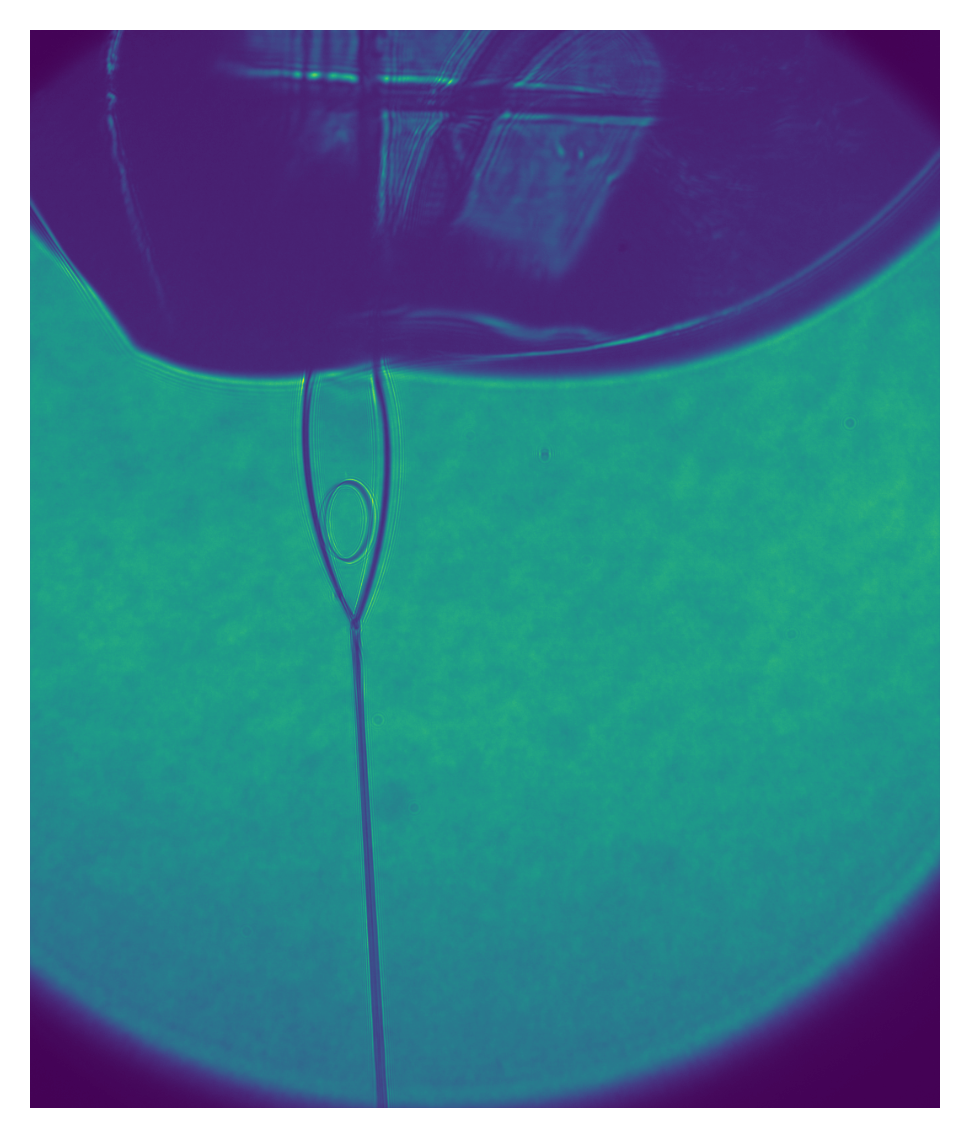

In [17]:
my_dpi = 300
plt.figure(figsize=(1200/my_dpi, 1400/my_dpi), dpi=my_dpi)
plt.axis('off')
plt.imshow(sidemic[1351])
plt.show()

In [ ]:
r = 201
run = RunDirectory(path=f'/gpfs/exfel/d/proc/SPB/202202/p003046/r0{r}')
sel = run.select('SPB_DET_AGIPD1M-1/DET/*CH0:xtdf', 'image.data')
train = xgm.coords['trainId'].data[gold_hit[0][10]]
tid, data = sel.train_from_id(train)



In [ ]:
import extra_geom
from extra_data import open_run, stack_detector_data
PREFIX = '/gpfs/exfel/exp/SPB/202202/p003046/'
geom = extra_geom.AGIPD_1MGeometry.from_crystfel_geom(PREFIX+'/scratch/geom/agipd_september_2022_v03.geom')
stacked = stack_detector_data(data, 'image.data')
rank = 61000
print(rank, gold_hit[0][rank], gold_hit[1][rank])
stacked_pulse = stacked[gold_hit[1][rank]]
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(30, 20))
#ax_cbar = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Create extra axes for the colorbar
geom.plot_data(stacked_pulse, vmin=0, vmax=1000, ax=ax0, colorbar=False)
stacked_pulse = stacked[gold_hit[1][rank]-1]
geom.plot_data(stacked_pulse, vmin=0, vmax=1000, ax=ax1, colorbar=False)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(30, 20))
#ax_cbar = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Create extra axes for the colorbar
stacked_pulse = stacked[gold_hit[1][rank]+1]
geom.plot_data(stacked_pulse, vmin=0, vmax=1000, ax=ax0, colorbar=False)
stacked_pulse = stacked[gold_hit[1][rank]-2]
geom.plot_data(stacked_pulse, vmin=0, vmax=1000, ax=ax1, colorbar=False)
plt.show()

In [ ]:
gold_hit = look_for_gold(xgm, radavg, I)

In [18]:
def plot_all(runs):
    from IPython.display import display, Markdown
    for run in np.array(runs, copy=False, ndmin=1):
        display(Markdown('<hr><h1 style="text-align:center"> <font size=32>Analysis of Run %d</font></h1>' % run))
        xgm, motor_x, motor_y, radavg, xgm2 = read_run_sync_trains(run, verbose=False)
        xgm, radavg, xgm2 = sync_pulses(xgm, radavg, xgm2)
        display(Markdown('<center>%d trains read and synchronized with %d pulses per train</center>' % (xgm.shape[0], xgm.shape[1])))
        I = integrate_q_range(radavg, verbose=False)
        slopes, intercept, R2, _ = linear_fit_trains(xgm, I)
        norm_R2 = xgm_range_normalized_R2(xgm, xgm2, R2)
        display(Markdown('<center><h2> Scattered vs Incident Intensity</h2></center>'))
        plot_xgm_vs_I(xgm, I, sample_trains=10)
        display(Markdown('<center><h2> Goodness of Fit Analysis</h2></center>'))
        plot_R2_vs_motor(R2, motor_x, motor_y)
        display(Markdown('<center><h2> Slope of Fit Analysis</h2></center>'))
        plot_R2_vs_slope(R2, slopes)

In [19]:
def log_linear_fits(xgm, I):
    n = 1
    R2_by_n = []
    while(n < len(xgm)):
        slopes, intercept, R2, _ = linear_fit_trains(xgm, I, n = n)
        R2_by_n.append(R2)
        n *= 2
    return R2_by_n        

In [20]:
def plot_log_linear_fits(R2_by_n, ax = None, total_n_trains = 1):
    if ax is None:
        plt.figure(figsize=(30,10))
        ax = plt.gca()
    for i,R2 in enumerate(R2_by_n):
        if(i < 4 or len(R2) < 3):
            continue
        ax.plot(np.linspace(0, total_n_trains, num=len(R2)-1), R2[:-1],label="n = %d" % (4**i))
    ax_i.set_xlabel('Number of Trains')
    ax_i.set_ylabel('$R^2$')
    ax.legend()

In [21]:
def combine_runs(runs):
    comb_xgm = None
    comb_motor_x = None
    comb_motor_y = None
    comb_radavg = None
    comb_xgm2 = None
    comb_I = None
    comb_R2 = None
    comb_slopes = None
    for run in runs:
        xgm, motor_x, motor_y, radavg, xgm2 = read_run_sync_trains(run, verbose=False)
        xgm, radavg, xgm2 = sync_pulses(xgm, radavg, xgm2)
        I = integrate_q_range(radavg, verbose=False)
        slopes, intercept, R2, _ = linear_fit_trains(xgm, I)
        #R2_by_n = log_linear_fits(xgm, I)
        #_, _, R2_2, _ = linear_fit_trains(xgm, I, n = 2)
        if comb_I is None:
            comb_I = I
        else:
            comb_I = xarray.concat((comb_I, I),'trainId')

        if comb_xgm is None:
            comb_xgm = xgm
        else:
            comb_xgm = xarray.concat((comb_xgm, xgm),'trainId')
            
        if comb_R2 is None:
            comb_R2 = R2
        else:
            comb_R2 = np.append(comb_R2, R2)
        if comb_slopes is None:
            comb_slopes = slopes
        else:
            comb_slopes = np.append(comb_slopes, slopes)
    R2_by_n = log_linear_fits(comb_xgm, comb_I)
    return comb_R2, comb_slopes, comb_xgm, comb_I, R2_by_n

In [22]:
comb_R2, comb_slopes, comb_xgm, comb_I, R2_by_n = combine_runs([83,84,85,86])

(631250, 256)
(631654, 256)
(631452, 256)
(556510, 256)


In [20]:
comb_R2, comb_slopes_phy, R2_by_n_phy = combine_runs([120,121,122,123])

(631452, 256)
(568024, 256)
(631250, 256)
(631856, 256)


ValueError: too many values to unpack (expected 3)

In [21]:
comb_R2_lj,comb_slopes_lj, comb_xgm_lj, comb_I_lj, R2_by_n_lj = combine_runs([188,189,190,191,192])

(631452, 256)
(631250, 256)
(631452, 256)
(297546, 256)
(301990, 256)


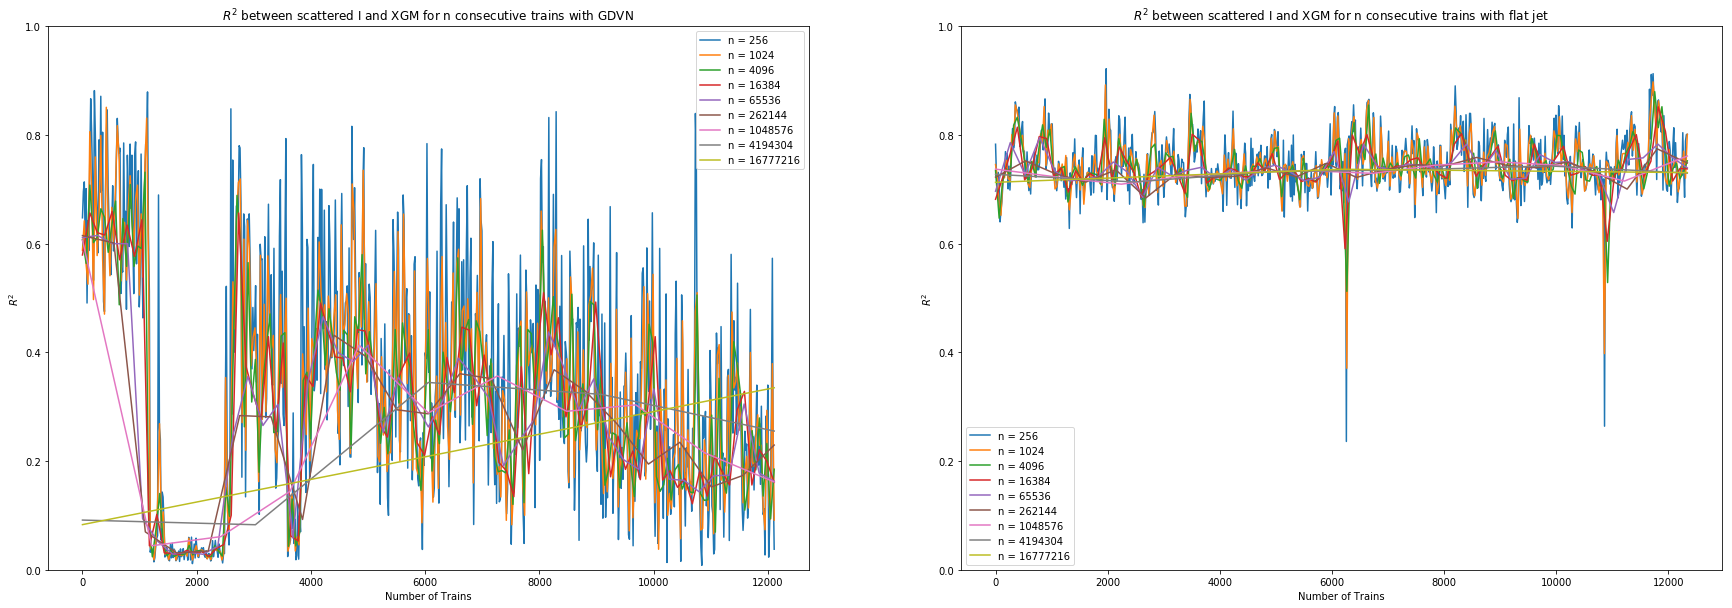

In [22]:
fig_handle = plt.figure(figsize=(30,10))
spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 2)
ax_i = fig_handle.add_subplot(spec_handle[0,0])
plot_log_linear_fits(R2_by_n, ax=ax_i, total_n_trains=len(comb_R2))
ax_i.set_ylim([0,1])
ax_i.set_title('$R^2$ between scattered I and XGM for n consecutive trains with GDVN')

ax_i = fig_handle.add_subplot(spec_handle[0,1])
plot_log_linear_fits(R2_by_n_lj, ax=ax_i, total_n_trains=len(comb_R2_lj))
ax_i.set_ylim([0,1])
ax_i.set_title('$R^2$ between scattered I and XGM for n consecutive trains with flat jet');

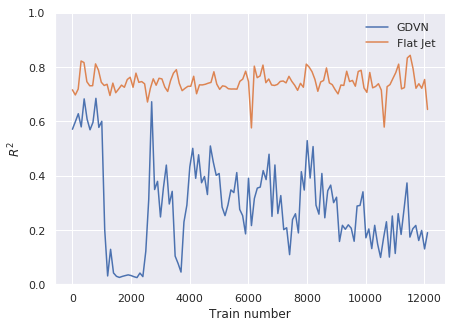

In [23]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set()

fig_handle = plt.figure(figsize=(7,5))
spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 1)
ax_i = fig_handle.add_subplot(spec_handle[0,0])
slopes, intercept, R2, _, Pearson_R = linear_fit_trains(comb_xgm, comb_I, n = 100, do_corr=True)
x = np.linspace(0,len(comb_xgm),num=len(R2))
plt.plot(x,R2,label='GDVN')
#plt.plot(x,Pearson_R**2,label='GDVN')
#ax_i.set_title('Correlation between scattered I and XGM for groups of 100 consecutive trains')
slopes, intercept, R2, _, Pearson_R = linear_fit_trains(comb_xgm_lj, comb_I_lj, n = 100, do_corr=True)
x = np.linspace(0,len(comb_xgm),num=len(R2))
plt.plot(x,R2,label='Flat Jet')
#plt.plot(x,Pearson_R**2,label='Flat Jet')
ax_i.set_ylim([0,1]);
ax_i.set_ylabel('$R^2$')
ax_i.set_xlabel('Train number')
ax_i.legend(frameon=False);
ax_i.spines['top'].set_visible(False)
ax_i.spines['right'].set_visible(False);
plt.savefig('correlation_I_xgm.pdf')


In [ ]:
fig_handle = plt.figure(figsize=(30,10))
spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 2)
ax_i = fig_handle.add_subplot(spec_handle[0,0])
ax_i.plot(comb_R2,'.')
ax_i.set_ylim([0,1])
ax_i.set_title('$R^2$ between scattered I and XGM with GDVN')
ax_i.set_xlabel('Number of Trains')
ax_i.set_ylabel('$R^2$')
    
ax_i = fig_handle.add_subplot(spec_handle[0,1])
ax_i.plot(comb_R2_lj,'.')
ax_i.set_ylim([0,1])
ax_i.set_title('$R^2$ between scattered I and XGM with flat jet');
ax_i.set_xlabel('Number of Trains')
ax_i.set_ylabel('$R^2$');

In [ ]:
fig_handle = plt.figure(figsize=(30,10))
spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 2)
ax_i = fig_handle.add_subplot(spec_handle[0,0])
ax_i.plot(comb_slopes,'.')
ax_i.set_title('Slopes for the fit between scattered I and XGM with GDVN')
ax_i.set_xlabel('Number of Trains')
ax_i.set_ylabel('Slope')
ax_i.set_ylim([0,60])
    
ax_i = fig_handle.add_subplot(spec_handle[0,1])
ax_i.plot(comb_slopes_lj,'.')
ax_i.set_title('Slopes for the fit between scattered I and XGM with flat jet');
ax_i.set_xlabel('Number of Trains')
ax_i.set_ylabel('Slope');
ax_i.set_ylim([0,60])

In [ ]:
plot_all(np.arange(148,151))

In [ ]:
plot_all(np.arange(184,198))

In [ ]:
plot_all(np.arange(128,147))

In [ ]:
run = 195
xgm, motor_x, motor_y, radavg, xgm2 = read_run_sync_trains(run, verbose=False)
xgm, radavg, xgm2 = sync_pulses(xgm, radavg, xgm2)
I = integrate_q_range(radavg, verbose=False)
slopes, intercept, R2, RelError = linear_fit_trains(xgm, I, n=1)
_, _, R2_xgm, _ = linear_fit_trains(xgm, xgm2, n=1)

In [ ]:
xgm_range = np.max(xgm,axis=1)-np.min(xgm,axis=1)

In [ ]:
plt.plot(xgm_range)

In [ ]:
plt.plot(R2/(R2_xgm*(np.std(R2)/np.std(R2_xgm))))

In [ ]:
plt.plot(1-R2_xgm)

In [ ]:
plt.plot(1-(1-R2)*(1/(1-R2_xgm))*(1-np.mean(R2_xgm)))

In [ ]:
plot_xgm_vs_I(xgm, I, sample_trains=10)

In [ ]:
plot_R2_vs_motor(RelError, motor_x, motor_y)

In [ ]:
plot_R2_vs_slope(RelError, slopes)

In [ ]:
plot_all(np.arange(184,198))

In [ ]:
plot_all(np.arange(146,161))

In [ ]:
plot_all(np.arange(146,148))

In [ ]:
plot_all(np.arange(148,159))

In [ ]:
plot_all(np.arange(190,194))

In [ ]:
plot_all(np.arange(194,197))

In [ ]:
gold_score = look_for_gold(xgm, radavg, I)

In [ ]:
plt.plot(gold_score.flatten())

In [ ]:
plot_all(np.arange(201,209))

In [ ]:
plot_all(np.arange(63,79))

In [ ]:
read_run_sync_trains(67, verbose=True)

In [ ]:
xgm, motor_x, motor_y, radavg = read_run_sync_trains(194)
xgm, radavg = sync_pulses(xgm, radavg)
I = integrate_q_range(radavg)

In [ ]:
slopes, intercept, R2 = linear_fit_trains(xgm, I, n=1)

In [ ]:
plt.plot(np.nanmean(xgm,axis=0))


In [ ]:
slopes, intercept, R2 = linear_fit_trains(xgm, I, n=1)

In [ ]:
np.mean(R2[:500])

In [ ]:
plot_R2_vs_slope(R2, slopes)

In [ ]:
radavg.coords['q']

In [19]:
run = 201
xgm, motor_x, motor_y, radavg, xgm2 = read_run_sync_trains(run, verbose=False)

(631250, 256)


In [20]:
I = integrate_q_range(radavg, verbose=False)

(array([1361, 1361, 1366, ...,  318, 1311,  246]), array([162, 141,   5, ...,   0,   0,   0]))
1361 141
1371 175
1366 143
1367 4
871 92


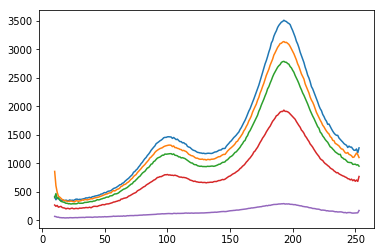

1 1376 145
10 1361 125
100 1359 85
1000 1380 45
10000 73 175


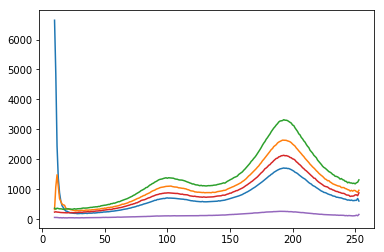

In [23]:
gold_score = look_for_gold(xgm, radavg, I)

In [28]:
data = plot_gold_hits(run, gold_score)

In [30]:
data.keys()

dict_keys(['SPB_DET_AGIPD1M-1/DET/2CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/10CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/15CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/4CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/14CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/11CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/3CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/5CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/8CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/0CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/12CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/7CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/6CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/9CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/1CH0:xtdf', 'SPB_DET_AGIPD1M-1/DET/13CH0:xtdf'])

In [31]:
import extra_geom
geom = extra_geom.AGIPD_1MGeometry.from_crystfel_geom('/gpfs/exfel/exp/SPB/202202/p003046'+'/scratch/geom/agipd_september_2022_v03.geom')

In [36]:
import extra_data  
modules_data = extra_data.stack_detector_data(data, 'image.data')

In [37]:
modules_data.shape

(202, 16, 512, 128)

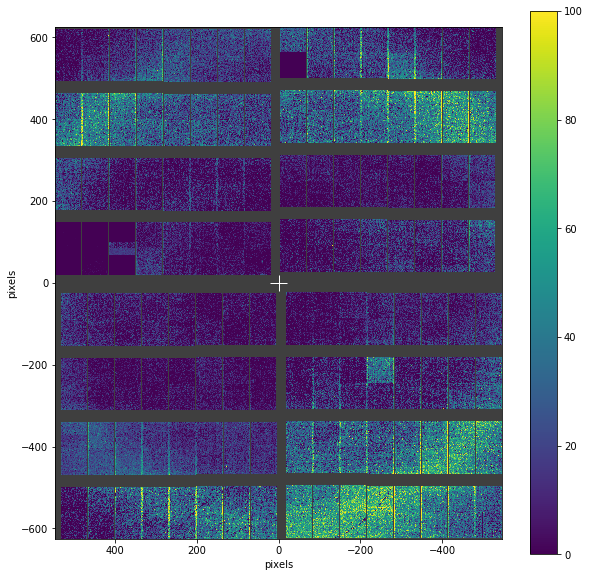

In [40]:
geom.plot_data(modules_data[0], vmin=0, vmax=100)